In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [103]:
import os
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import h5py
sys.path.append('/home/jma819/post_cmfe_analysis')
#sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis')
from matplotlib import pyplot as plt
import dlc_utils
import av
from matplotlib import animation, rc
from IPython.display import HTML

In [12]:
from importlib import reload
reload(dlc_utils)

<module 'dlc_utils' from '/home/jma819/post_cmfe_analysis/dlc_utils.py'>

In [13]:
#dlc_directory = '/volumes/My_Passport/dlc_analysis/behavcamvideos/open_field_miniscope/'
dlc_directory = '/projects/b1118/behaviorvideos/'

In [14]:
experiment_folders = [folder for folder in os.listdir(dlc_directory) if '_H' in folder]

In [15]:
experiment_folders

['GRIN013_H13_M33_S54']

In [16]:
for folder in tqdm(experiment_folders):
    output_directory = dlc_directory+folder+'/'
    session_name = folder
    print(folder)
    dlc_output_files = os.listdir(output_directory)
    dlc_output_files.sort()
    
    names = []
    dlc_dfs = []
    

100%|██████████| 1/1 [00:00<00:00, 728.30it/s]

GRIN013_H13_M33_S54


In [8]:
dlc_output_files

['GRIN013_H13_M33_S54_compiled_session_02112021.csv',
 'GRIN013_H13_M33_S54_compiled_session_02112021.h5',
 'GRIN013_H13_M33_S54_dlc_tracking_foranalysis_02112021.csv',
 'behavCam01.avi',
 'behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5',
 'behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000_labeled.mp4',
 'behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000includingmetadata.pickle',
 'behavCam02.avi',
 'behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5',
 'behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000_labeled.mp4',
 'behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000includingmetadata.pickle',
 'behavCam03.avi',
 'behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5',
 'behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000_labeled.mp4',
 'behavCam03DLC_resnet50_Open_Field_v2Jan27shuffle1_150000includingmetadata.pickle',
 'behavCam04.avi',
 'behavCam04DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5',
 'behavCam04DLC_resnet50_

In [104]:
dlc_output = pd.read_hdf('/projects/b1118/behaviorvideos/GRIN013_H13_M33_S54/behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5')
#dlc_output = dlc_utils.calculate_centroid(dlc_output)
#should also append a time column for alignment to avi file
time_within_movie_seconds = np.linspace(0, 50, 1000)

In [105]:
dlc_output.head()

scorer    DLC_resnet50_Open_Field_v2Jan27shuffle1_150000              \
bodyparts                                       ear_left               
coords                                                 x           y   
0                                             292.508667  357.506012   
1                                             292.862366  357.351593   
2                                             293.086090  357.166443   
3                                             292.763947  357.294891   
4                                             293.038818  357.544952   

scorer                                                               \
bodyparts              ear_right                          tail_base   
coords    likelihood           x           y likelihood           x   
0           0.074033  300.513000  364.337311   0.180357  253.353836   
1           0.093176  302.479034  370.733826   0.303444  253.549255   
2           0.185885  302.335846  370.647156   0.392228  253.383041   
3           0.114862  301.174866  364.848114   0.248863  253.609161   
4           0.089646  302.475433  370.651306   0.233052  253.424500   

scorer                                                                   
bodyparts                        miniscope_light                         
coords              y likelihood               x           y likelihood  
0          375.582794        1.0      307.633392  355.723877   0.008590  
1          375.880615        1.0      307.503723  355.476562   0.008776  
2          375.891968        1.0      307.716858  355.432251   0.015284  
3          375.824310        1.0      307.500061  355.350494   0.008182  
4          375.775513        1.0      307.749084  355.445374   0.010289

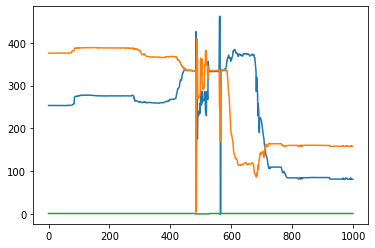

In [11]:
label = 'tail_base'
plt.plot(dlc_output['DLC_resnet50_Open_Field_v2Jan27shuffle1_150000'][label]['x'])
plt.plot(dlc_output['DLC_resnet50_Open_Field_v2Jan27shuffle1_150000'][label]['y'])
plt.plot(dlc_output['DLC_resnet50_Open_Field_v2Jan27shuffle1_150000'][label]['likelihood'])

In [12]:
## find regions where likelihood is less than maybe .9-1
low_likelihood_indicies = dlc_output.loc[dlc_output['DLC_resnet50_Open_Field_v2Jan27shuffle1_150000'][label]['likelihood']<0.9].index
#if want to get time 
#low_likelihood_times = time_within_movie_seconds[list(low_likelihood_indicies)]
#remove coordinate values from low likelihood regions 
dlc_output.loc[low_likelihood_indicies, ('DLC_resnet50_Open_Field_v2Jan27shuffle1_150000', 'tail_base', 'x')]=np.nan
dlc_output.loc[low_likelihood_indicies, ('DLC_resnet50_Open_Field_v2Jan27shuffle1_150000', 'tail_base', 'y')]=np.nan

In [13]:
#dlc_output.loc[low_likelihood_indicies]

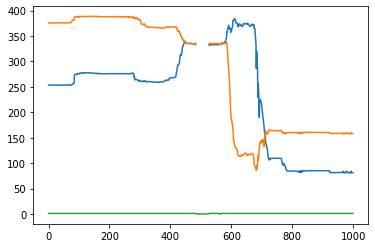

In [14]:
label = 'tail_base'
plt.plot(dlc_output['DLC_resnet50_Open_Field_v2Jan27shuffle1_150000'][label]['x'])
plt.plot(dlc_output['DLC_resnet50_Open_Field_v2Jan27shuffle1_150000'][label]['y'])
plt.plot(dlc_output['DLC_resnet50_Open_Field_v2Jan27shuffle1_150000'][label]['likelihood'])

In [15]:
coordinates_delta_df = dlc_utils.difference_df(dlc_output)

In [16]:
coordinates_delta_df.head()

miniscope_light           tail_base           ear_right            \
coords               x         y         x         y         x         y   
0                  NaN       NaN       NaN       NaN       NaN       NaN   
1            -0.129669 -0.247314  0.195419  0.297821  1.966034  6.396515   
2             0.213135 -0.044312 -0.166214  0.011353 -0.143188 -0.086670   
3            -0.216797 -0.081757  0.226120 -0.067657 -1.160980 -5.799042   
4             0.249023  0.094879 -0.184662 -0.048798  1.300568  5.803192   

        ear_left            
coords         x         y  
0            NaN       NaN  
1       0.353699 -0.154419  
2       0.223724 -0.185150  
3      -0.322144  0.128448  
4       0.274872  0.250061

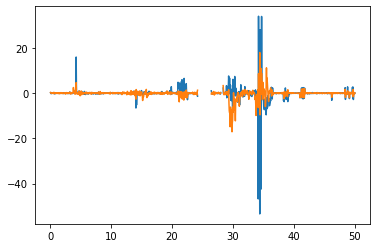

In [17]:
# much better but still need to remove instances of rapid switching here 
label = 'tail_base'
plt.plot(time_within_movie_seconds, coordinates_delta_df[label]['x'])
plt.plot(time_within_movie_seconds, coordinates_delta_df[label]['y'])


In [18]:
df_columns = list(dlc_output.columns)
velocity_df = pd.DataFrame(np.transpose(np.array([np.array([dlc_utils.velocity(coordinates_delta_df[body_part]['x'].values[frame],coordinates_delta_df[body_part]['y'].values[frame]) for frame in range(len(coordinates_delta_df))]) for body_part in list(set([df_columns[item][1] for item in range(len(df_columns))]))])), 
                                       columns=list(set([df_columns[item][1] for item in range(len(df_columns))]))) 
for body_part in list(set([df_columns[item][1] for item in range(len(df_columns))])):
    velocity_df[body_part+'_likelihood']=dlc_output[df_columns[0][0]][body_part]['likelihood'].values

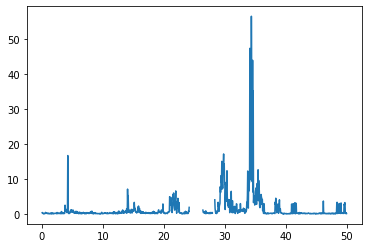

In [19]:
## for now this might be good enough to pick out regions for later review
label = 'tail_base'
plt.plot(time_within_movie_seconds, velocity_df[label])


In [20]:
# check if alignment to msCam videos is working 

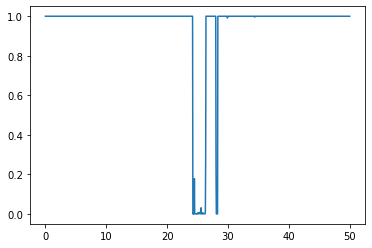

In [21]:
velocity_df
plt.plot(time_within_movie_seconds, velocity_df['tail_base_likelihood'])

In [22]:
## compiling all files in recording session to check msCam alignment
dlc_directory 

'/projects/b1118/behaviorvideos/'

In [23]:
session_name

'GRIN013_H13_M33_S54'

In [44]:
for folder in tqdm(experiment_folders):
    output_directory = dlc_directory+folder+'/'
    session_name = folder
    print(folder)
    dlc_output_files = os.listdir(output_directory)
    dlc_output_files.sort()


100%|██████████| 1/1 [00:00<00:00, 417.34it/s]

GRIN013_H13_M33_S54


In [47]:
#dlc_output_files[0:10]

In [108]:
list(set(dlc_output.columns.get_level_values(1)))

['miniscope_light', 'tail_base', 'ear_right', 'ear_left']

In [ ]:
for folder in tqdm(experiment_folders):
    output_directory = dlc_directory+folder+'/'
    session_name = folder
    print(folder)
    dlc_output_files = os.listdir(output_directory)
    dlc_output_files.sort()    
    names = []
    dlc_dfs = []
    for output_file in dlc_output_files[0:10]:
        if output_file.endswith('000.h5'):
            print(output_file)
            dlc_output = pd.read_hdf(output_directory + output_file)
            
            ## before calculating centroid remove regions where 
            # find regions where likelihood is less than maybe .9-1
            for body_part in list(set(dlc_output.columns.get_level_values(1))):
                low_likelihood_indicies = dlc_output.loc[dlc_output['DLC_resnet50_Open_Field_v2Jan27shuffle1_150000'][body_part]['likelihood']<0.9].index
                #remove coordinate values from low likelihood regions 
                dlc_output.loc[low_likelihood_indicies, ('DLC_resnet50_Open_Field_v2Jan27shuffle1_150000', body_part, 'x')]=np.nan
                dlc_output.loc[low_likelihood_indicies, ('DLC_resnet50_Open_Field_v2Jan27shuffle1_150000', body_part, 'y')]=np.nan
          
            dlc_output = dlc_utils.calculate_centroid(dlc_output)
            dlc_output.head()
            coordinates_delta_df = dlc_utils.difference_df(dlc_output)
            df_columns = list(dlc_output.columns)

            print('calculating velocity')
            velocity_df = pd.DataFrame(np.transpose(np.array([np.array([dlc_utils.velocity(coordinates_delta_df[body_part]['x'].values[frame],coordinates_delta_df[body_part]['y'].values[frame]) for frame in range(len(coordinates_delta_df))]) for body_part in list(set([df_columns[item][1] for item in range(len(df_columns))]))])), 
                                       columns=list(set([df_columns[item][1] for item in range(len(df_columns))]))) 
            for body_part in list(set([df_columns[item][1] for item in range(len(df_columns))])):
                velocity_df[body_part+'_likelihood']=dlc_output[df_columns[0][0]][body_part]['likelihood'].values
            
            names.append(output_file)
            dlc_dfs.append(velocity_df)

    session_compiled = pd.concat(dlc_dfs, keys=names)

    #save compiled session 
    session_compiled.to_hdf(output_directory+session_name+'_compiled_session_02112021.h5', key='df')
    session_compiled.to_csv(output_directory+session_name+'_compiled_session_02112021.csv')

    #create behavior data aligned to the msCam frames
    #need to have switch here for msCam and BehavCam cam #s
    #in these recordings behavcam records at faster framerate (30fps vs 20fps) so will have more frames
    timsestamps_file = output_directory+'timestamp.dat'
    frame_clock_df = pd.read_table(timsestamps_file)
    Cam0_timestamps = frame_clock_df[frame_clock_df['camNum'] == 0]  
    Cam1_timestamps = frame_clock_df[frame_clock_df['camNum'] == 1]
    if len(Cam1_timestamps)>len(Cam0_timestamps):
        msCam_camnum=0
        behavCam_camnum=1
    elif len(Cam1_timestamps)<len(Cam0_timestamps):
        msCam_camnum=1
        behavCam_camnum=0
    else:
        print('check timestamp file')
        break   

    # changing selection of frames from session compiled dataframe to account for 1 indexing of frames in timestamp file -- should be fixed 
    aligned = dlc_utils.downsample_dlc_to_behavior(output_directory+session_name+'_compiled_session_02112021.h5', output_directory+'timestamp.dat', 
                                                   msCam_camnum, behavCam_camnum)

In [78]:
    aligned_td = aligned.set_index(pd.to_timedelta(np.linspace(0, aligned['sys_clock_behavCam'].values[-1]/1000, len(aligned)), unit='s'), drop=False)
    
    #smooth data by downsampling and interpolating 
    velocities_for_smoothing = aligned_td[list(set(dlc_output.columns.get_level_values(1)))]
    dont_smooth = aligned_td[[label for label in list(set(aligned_td.columns)) if label not in list(set(dlc_output.columns.get_level_values(1)))]]
    
    interpolated = dlc_utils.downsample_and_interpolate(velocities_for_smoothing, '.05S', '1S', 'linear')
    interpolated_for_output = pd.concat([interpolated.reset_index(drop=True), dont_smooth.reset_index(drop=True)], axis=1).set_index(pd.to_timedelta(np.linspace(0, dont_smooth['sys_clock_behavCam'].values[-1]/1000, len(aligned)), unit='s'), drop=False)


    aligned_td.to_csv(output_directory+session_name+'_dlc_tracking_foranalysis_unsmoothed_02112021.csv')
    interpolated_for_output.to_csv(output_directory+session_name+'_dlc_tracking_foranalysis_02112021.csv')
    output_directory+session_name+'_dlc_tracking_foranalysis.csv'

'/projects/b1118/behaviorvideos/GRIN013_H13_M33_S54/GRIN013_H13_M33_S54_dlc_tracking_foranalysis.csv'

In [79]:
#velocities_for_smoothing

In [80]:
## load results to plot examples of movement events from behavCam videos
aligned_td = pd.read_csv('/projects/b1118/behaviorvideos/GRIN013_H13_M33_S54/GRIN013_H13_M33_S54_compiled_session_02112021.csv')
interpolated = pd.read_csv('/projects/b1118/behaviorvideos/GRIN013_H13_M33_S54/GRIN013_H13_M33_S54_dlc_tracking_foranalysis_02112021.csv')

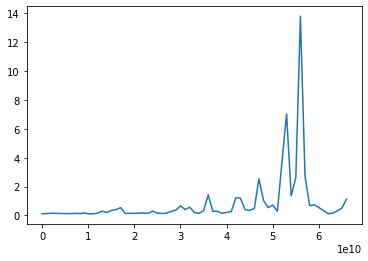

In [81]:
plt.plot(interpolated_for_output['tail_base'])

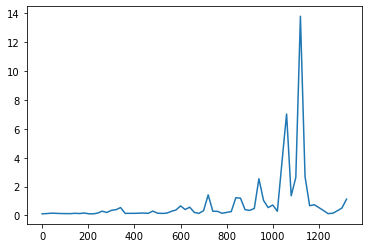

In [82]:
plt.plot(interpolated['tail_base'])

(0, 60)

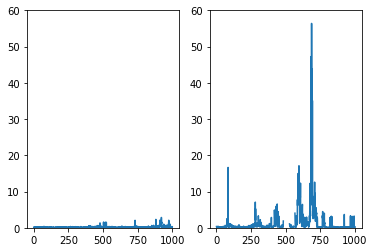

In [98]:
frames_within_movie = np.linspace(0, 1000, 1000)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(frames_within_movie, session_compiled.loc['behavCam01DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5']['tail_base'])
ax1.set_ylim(0, 60)
ax2.plot(frames_within_movie, session_compiled.loc['behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000.h5']['tail_base'])
ax2.set_ylim(0, 60)

In [91]:
video = av.open('/projects/b1118/behaviorvideos/GRIN013_H13_M33_S54/behavCam02DLC_resnet50_Open_Field_v2Jan27shuffle1_150000_labeled.mp4')

In [85]:
total_frames = video.streams.video[0].frames

In [86]:
total_frames

1000

In [92]:
movie_images = {}
for i, frame in enumerate(video.decode(video=0)):
    img = frame.to_image()  # PIL image
    movie_images[i] = img
    print("Frame: %d/%d ..." % (i, total_frames))

Frame: 0/1000 ...
Frame: 1/1000 ...
Frame: 2/1000 ...
Frame: 3/1000 ...
Frame: 4/1000 ...
Frame: 5/1000 ...
Frame: 6/1000 ...
Frame: 7/1000 ...
Frame: 8/1000 ...
Frame: 9/1000 ...
Frame: 10/1000 ...
Frame: 11/1000 ...
Frame: 12/1000 ...
Frame: 13/1000 ...
Frame: 14/1000 ...
Frame: 15/1000 ...
Frame: 16/1000 ...
Frame: 17/1000 ...
Frame: 18/1000 ...
Frame: 19/1000 ...
Frame: 20/1000 ...
Frame: 21/1000 ...
Frame: 22/1000 ...
Frame: 23/1000 ...
Frame: 24/1000 ...
Frame: 25/1000 ...
Frame: 26/1000 ...
Frame: 27/1000 ...
Frame: 28/1000 ...
Frame: 29/1000 ...
Frame: 30/1000 ...
Frame: 31/1000 ...
Frame: 32/1000 ...
Frame: 33/1000 ...
Frame: 34/1000 ...
Frame: 35/1000 ...
Frame: 36/1000 ...
Frame: 37/1000 ...
Frame: 38/1000 ...
Frame: 39/1000 ...
Frame: 40/1000 ...
Frame: 41/1000 ...
Frame: 42/1000 ...
Frame: 43/1000 ...
Frame: 44/1000 ...
Frame: 45/1000 ...
Frame: 46/1000 ...
Frame: 47/1000 ...
Frame: 48/1000 ...
Frame: 49/1000 ...
Frame: 50/1000 ...
Frame: 51/1000 ...
Frame: 52/1000 ...
Fra

In [101]:
video.close()

In [ ]:
[movie_images[i] for i in range(500, 750, 250)]

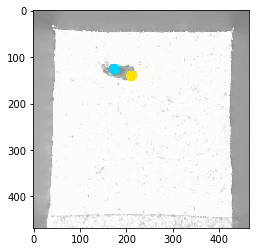

In [100]:
plt.imshow(movie_images[700])

In [104]:
fig = plt.figure()
ani = animation.ArtistAnimation(fig, [movie_images[i] for i in range(500, 750, 250)], interval=50, blit=True, repeat_delay=1000)
HTML(ani.to_html5_video())

Traceback (most recent call last):
  File "/home/jma819/.conda/envs/jupyter_env/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/jma819/.conda/envs/jupyter_env/lib/python3.8/site-packages/matplotlib/animation.py", line 953, in _start
    self._init_draw()
  File "/home/jma819/.conda/envs/jupyter_env/lib/python3.8/site-packages/matplotlib/animation.py", line 1522, in _init_draw
    for artist in f:
TypeError: 'Image' object is not iterable


RuntimeError: Requested MovieWriter (ffmpeg) not available

<Figure size 432x288 with 0 Axes>